In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

#Importare il file
file_url = "https://proai-datasets.s3.eu-west-3.amazonaws.com/aviation-accidents.csv"
df = pd.read_csv(file_url)

In [ ]:
# Visualizza le prime righe del dataset per capire la struttura
df.head()

,date,type,registration,operator,fatalities,location,country,cat,year
0,date unk.,Antonov An-12B,T-1206,Indonesian AF,NaN,NaN,Unknown country,U1,unknown
1,date unk.,Antonov An-12B,T-1204,Indonesian AF,NaN,NaN,Unknown country,U1,unknown
2,date unk.,Antonov An-12B,T-1201,Indonesian AF,NaN,NaN,Unknown country,U1,unknown
3,date unk.,Antonov An-12BK,NaN,Soviet AF,NaN,Tiksi Airport (IKS),Russia,A1,unknown
4,date unk.,Antonov An-12BP,CCCP-11815,Soviet AF,0,Massawa Airport ...,Eritrea,A1,unknown


In [ ]:
# Controlla per eventuali valori nulli
df.isnull().sum()

,0
date,0
type,0
registration,1548
operator,4
fatalities,3938
location,948
country,0
cat,0
year,0


In [ ]:
# Correggo i valori in 'fatalities'
df['fatalities'] = df['fatalities'].apply(lambda x: eval(x) if pd.notna(x) else 0)

In [ ]:
# Rimuoviamo eventuali righe con dati mancanti
df = df.dropna(subset=['registration',"location","operator"])
df.isnull().sum()

,0
date,0
type,0
registration,0
operator,0
fatalities,0
location,0
country,0
cat,0
year,0


In [ ]:
# Calcoliamo il numero di incidenti per nazione
accidents_by_country = df.groupby('country').size()

In [ ]:
# Ordiniamo per visualizzare le prime nazioni con più incidenti
accidents_by_country = accidents_by_country.sort_values(ascending=False)

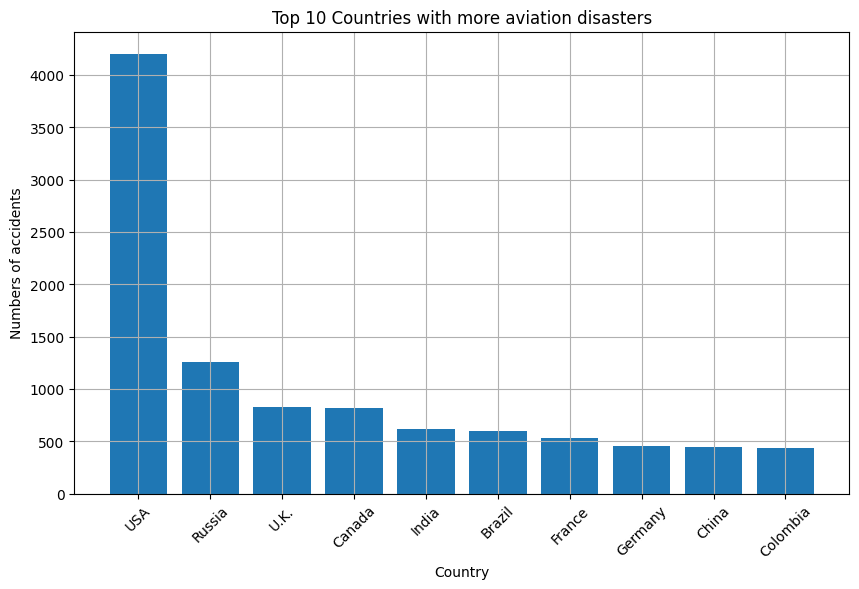

In [ ]:
# Grafico delle prime 10 nazioni con più incidenti
plt.figure(figsize=(10, 6))
plt.bar(accidents_by_country.head(10).index,accidents_by_country.head(10))
plt.title('Top 10 Countries with more aviation disasters')
plt.xlabel('Country')
plt.ylabel('Numbers of accidents')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

E' evidente che il maggior numero di incidenti si verifica negli **USA**, con un distacco notevole dagli altri paesi.

In [ ]:
# Sostituisco i valori sconosciuti con NaT
df['date'] = df['date'].replace('date unk.', pd.NaT)

In [ ]:
# Convertiamo la colonna 'date' in formato datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

<ipython-input-10-8f13130044f8>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date'], errors='coerce')


In [ ]:
# Aggiungiamo una colonna che verifica se l'anno è NaN nella data
df['year_from_date'] = df['date'].dt.year

In [ ]:
# Filtriamo le righe dove 'year_from_date' è NaN e controlliamo se nella colonna 'year' è presente un anno
missing_year_from_date = df[df['year_from_date'].isna() & df['year'].notna()]

In [ ]:
# Copia l'anno dalla colonna 'year' alla colonna 'date' per le righe dove 'date' è NaT
df.loc[df['date'].isna(), 'date'] = pd.to_datetime(df.loc[df['date'].isna(), 'year'].astype(str), format='%Y',errors='coerce')
df.isnull().sum()

,0
date,30
type,0
registration,0
operator,0
fatalities,0
location,0
country,0
cat,0
year,0
year_from_date,326


In [ ]:
#Rimuoviamo la colonna creata
df=df.drop(columns=['year_from_date'])
df.head()

,date,type,registration,operator,fatalities,location,country,cat,year
4,NaT,Antonov An-12BP,CCCP-11815,Soviet AF,0,Massawa Airport ...,Eritrea,A1,unknown
6,NaT,Antonov An-2,CCCP-N574,"GUSMP, Directorate of Polar Aviation",0,unknown,Russia,A1,unknown
7,NaT,Antonov An-2,CCCP-01216,Aeroflot,0,Chita region,Russia,A2,unknown
9,NaT,Antonov An-26,01 red,Soviet AF,0,Orenburg Air Base,Russia,O1,unknown
10,NaT,Antonov An-26,RA-47415,Russian AF,0,Belgorod Airport...,Russia,A1,unknown


In [ ]:
# Rimuoviamo eventuali righe con date ancora mancanti
df = df.dropna(subset=["date"])

In [ ]:
# Calcoliamo il numero di incidenti per anno
accidents_by_year = df.groupby(df['date'].dt.year).size()

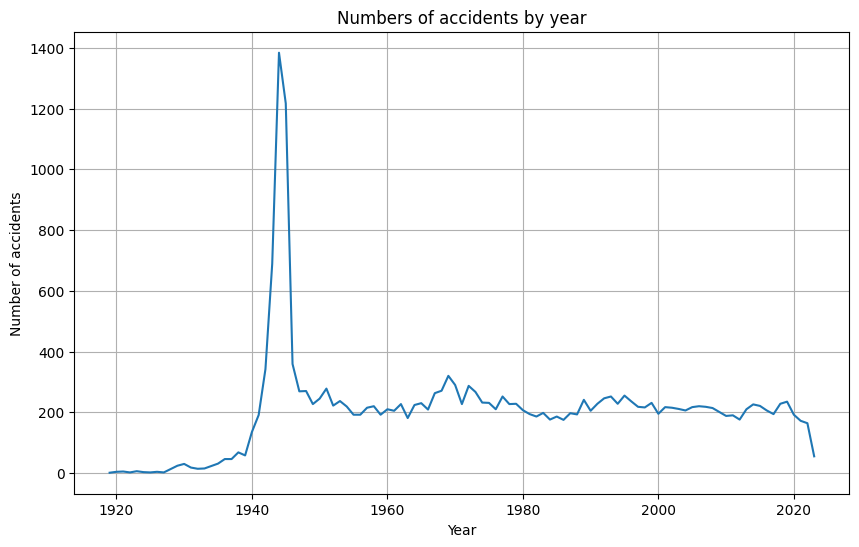

In [ ]:
# Grafico della distribuzione degli incidenti per anno
plt.figure(figsize=(10, 6))
plt.plot(accidents_by_year.index, accidents_by_year.values)
plt.title('Numbers of accidents by year')
plt.xlabel('Year')
plt.ylabel('Number of accidents')
plt.grid(True)
plt.show()

Il picco si ottiene intorno all'anno **1942**, mentre negli ultimi anni c'è stata una diminuzione degli incidenti.

In [ ]:
# Aggiungiamo una colonna per il giorno della settimana (0 = Lunedì, 6 = Domenica)
df['day_week'] = df['date'].dt.dayofweek

# Calcoliamo la distribuzione degli incidenti per giorno della settimana
accidents_by_day = df.groupby('day_week').size()

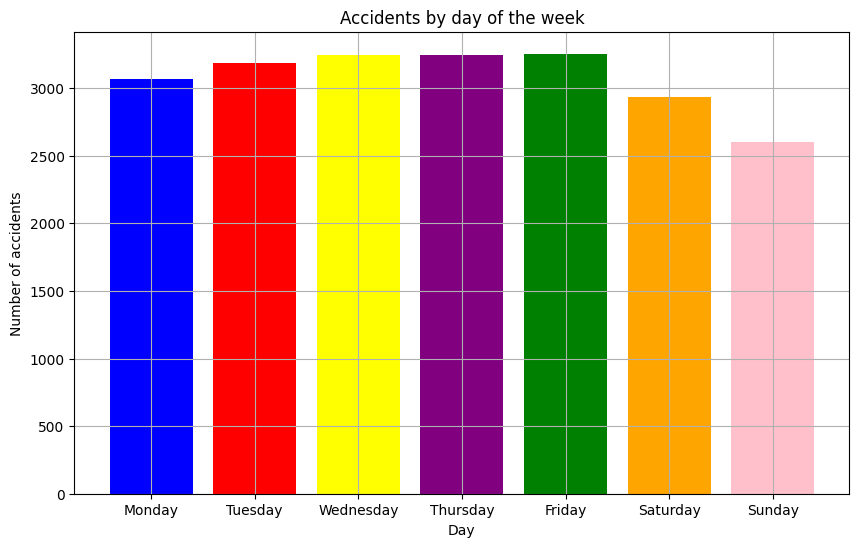

In [ ]:
# Grafico della distribuzione per giorno della settimana
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
colors=["blue","red","yellow","purple","green","orange","pink"]
plt.figure(figsize=(10, 6))
plt.bar(accidents_by_day.index, accidents_by_day.values, tick_label=days,color=colors)
plt.title('Accidents by day of the week')
plt.xlabel('Day')
plt.ylabel('Number of accidents')
plt.grid()
plt.show()

Non è evidenziato un particolare giorno in cui si verificano più incidenti ma abbiamo un andamento pressochè **costante**, eccezion fatta per la domenica (ipoteticamente perchè ci sono meno voli).

In [ ]:
# Calcoliamo la somma delle morti per tipo di velivolo
type_airplane = df.groupby('type')['fatalities'].sum()

In [ ]:
# Ordiniamo per visualizzare i tipi di velivolo con più morti
type_airplane = type_airplane.sort_values(ascending=False)

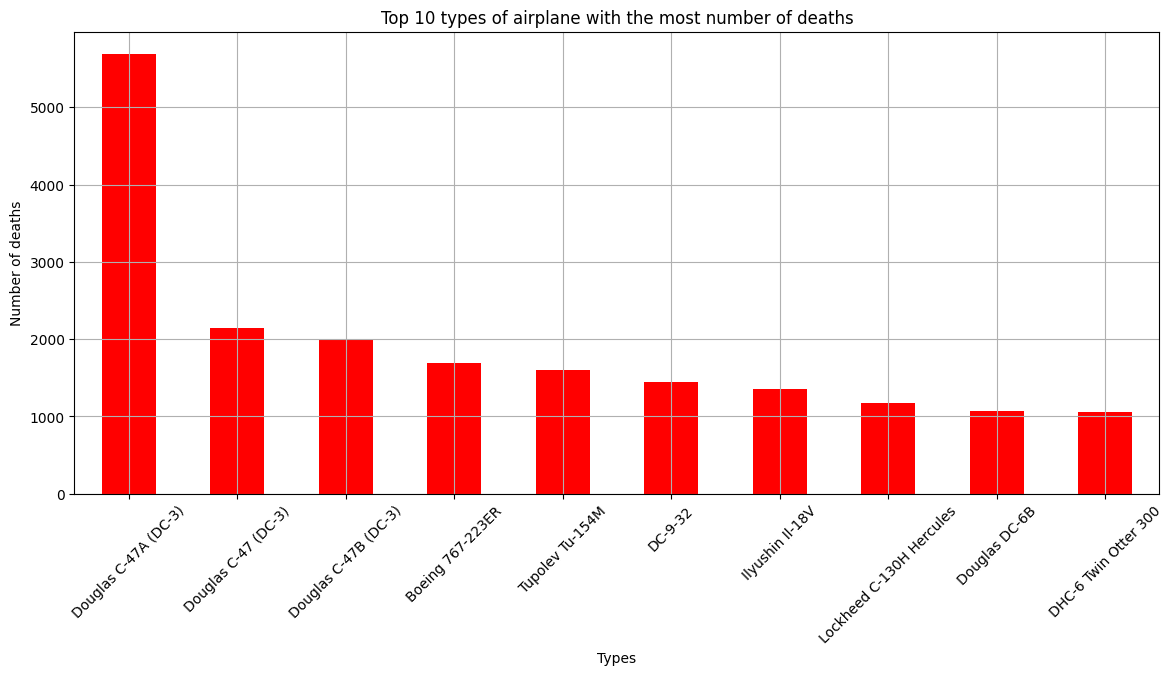

In [ ]:
# Grafico dei tipi di velivolo con più morti
plt.figure(figsize=(14, 6))
type_airplane.head(10).plot(kind='bar', color='red')
plt.title('Top 10 types of airplane with the most number of deaths')
plt.xlabel('Types')
plt.ylabel('Number of deaths')
plt.xticks(rotation=45)
plt.grid()
plt.show()


Il modello **Douglas C-47A (DC-3)** risulta essere il più pericoloso.

In [ ]:
# Calcoliamo il numero di incidenti per compagnia
accidents_by_operator = df.groupby('operator').size()

In [ ]:
# Ordiniamo per visualizzare le prime nazioni con più incidenti
accidents_by_operator = accidents_by_operator.sort_values(ascending=False)

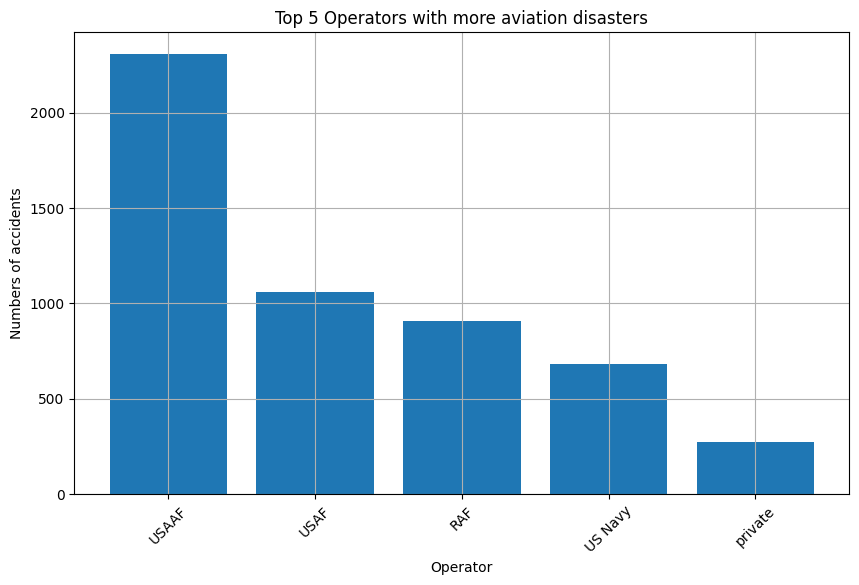

In [ ]:
# Grafico delle prime 5 compagnie con più incidenti
plt.figure(figsize=(10, 6))
plt.bar(accidents_by_operator.head().index,accidents_by_operator.head())
plt.title('Top 5 Operators with more aviation disasters')
plt.xlabel('Operator')
plt.ylabel('Numbers of accidents')
plt.xticks(rotation=45)
plt.grid()
plt.show()

La compagnia **USAAF** risulta essere la più pericolosa.

In [ ]:
# Filtrare il dataset pre e post 11 settembre 2001
pre_11_sept = df[df['date'] < '2001-09-11']
post_11_sept = df[df['date'] >= '2001-09-11']

In [ ]:
# Calcolare la media giornaliera delle fatalità
mean_pre_11_sept = pre_11_sept['fatalities'].mean()
mean_post_11_sept = post_11_sept['fatalities'].mean()

print(f"Day mean of fatalities before the 11th of September, 2001: {mean_pre_11_sept}")
print(f"Day mean of fatalities after the 11th of September, 2001: {mean_post_11_sept}")

Day mean of fatalities before the 11th of September, 2001: 6.331521103706302
Day mean of fatalities after the 11th of September, 2001: 4.539467749210645


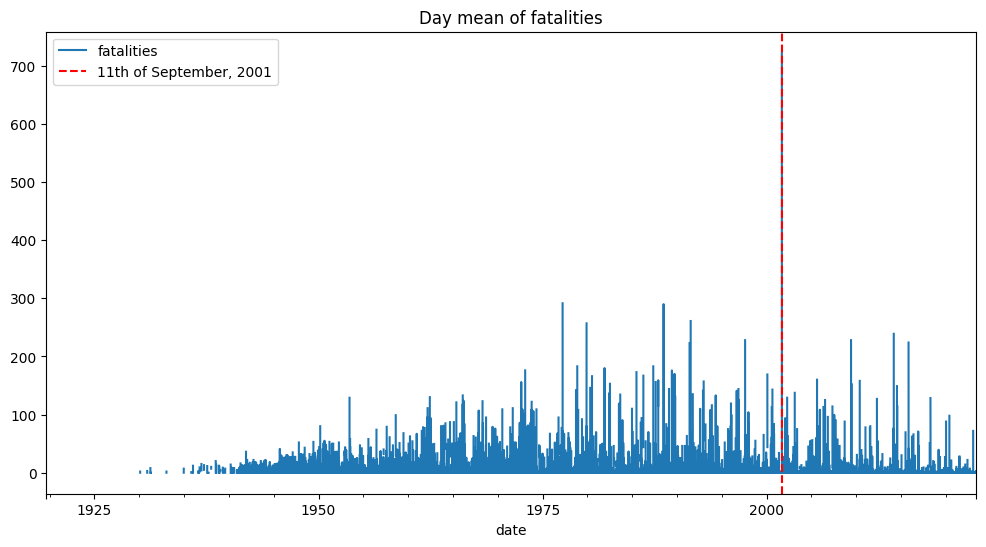

In [ ]:
# Grafico della distribuzione degli incidenti pre e post 11 settembre
plt.figure(figsize=(12, 6))
df.set_index('date')['fatalities'].resample('D').mean().plot(title='Day mean of fatalities')
plt.axvline(x=pd.Timestamp('2001-09-11'), color='r', linestyle='--', label='11th of September, 2001')
plt.legend()
plt.show()

La media giornaliera delle morti è **diminuita** dopo l'11 Settembre 2001.

In [ ]:
# Contiamo il numero di incidenti per tipo di velivolo e operatore
accidents_operator_type = df.groupby(['type', 'operator']).size().reset_index(name='accidents')

In [ ]:
# Calcoliamo il numero di morti per tipo di velivolo e operatore
deaths_operator_type = df.groupby(['type'])['fatalities'].sum().reset_index(name='deaths')

In [ ]:
# Uniamo i due dataframe per avere tutte le informazioni in un unico posto
analysis = pd.merge(accidents_operator_type, deaths_operator_type)

<ipython-input-32-387792102dd7>:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Type of airplane', bbox_to_anchor=(1.05, 1), loc='upper left')


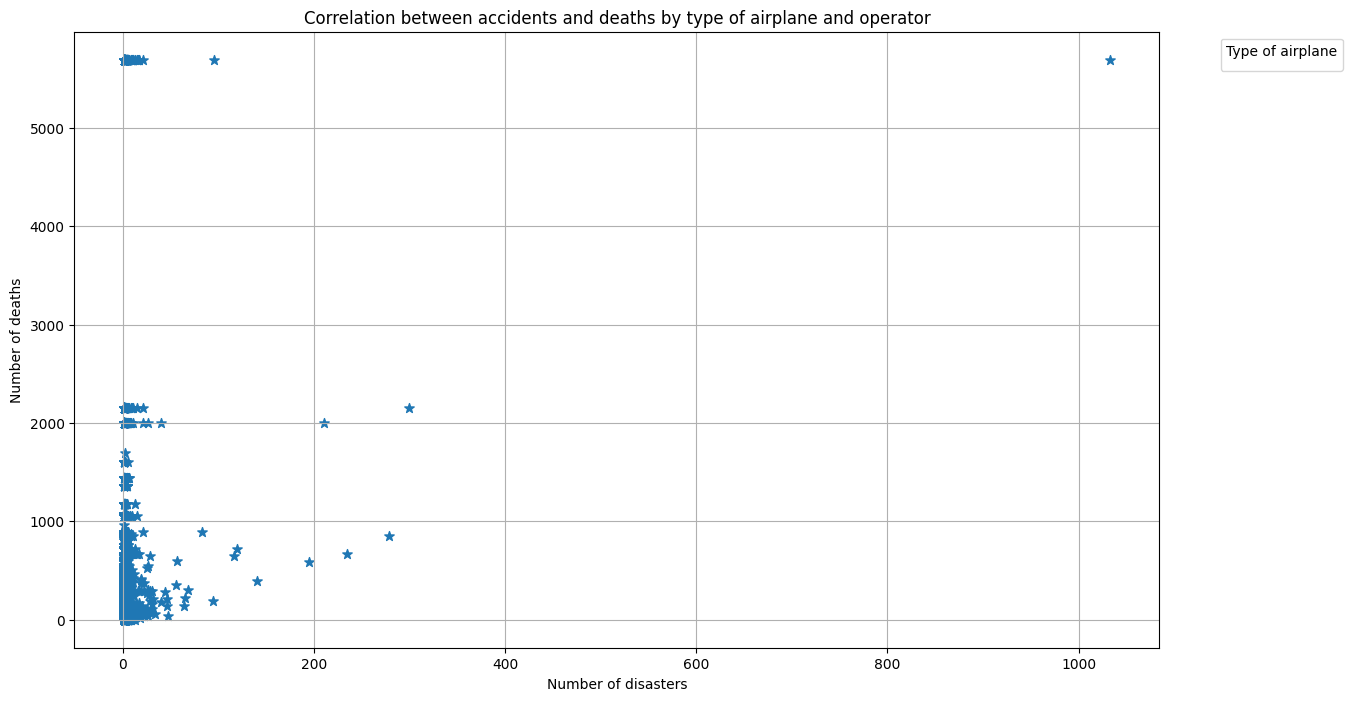

In [ ]:
# Grafico a dispersione per incidenti e morti
plt.figure(figsize=(14, 8))
plt.scatter(x=analysis['accidents'], y=analysis['deaths'],s=50,marker="*")

plt.title('Correlation between accidents and deaths by type of airplane and operator')
plt.xlabel('Number of disasters')
plt.ylabel('Number of deaths')
plt.legend(title='Type of airplane', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.show()


In [ ]:
# Possiamo vedere quali velivoli hanno il minor numero di incidenti e morti in base al tipo e all'operatore
analysis = analysis.sort_values(by=['deaths', 'accidents'])
analysis

,type,operator,accidents,deaths
0,A.W. AW-650 Argosy 101,Duncan Aviation,1,0
1,A.W. AW-650 Argosy 101,U.S. Dept of Interior,1,0
2,A.W. AW-650 Argosy 101,Zantop,1,0
3,A.W. AW-650 Argosy 102,Air Bridge Carriers,1,0
5,A.W. AW-650 Argosy 222,IPEC,1,0
...,...,...,...,...
6327,Douglas C-47A (DC-3),Aeroflot,17,5691
6403,Douglas C-47A (DC-3),CNAC,17,5691
6480,Douglas C-47A (DC-3),Indian Airlines,21,5691
6662,Douglas C-47A (DC-3),USAF,95,5691


In [ ]:
# Creiamo un cartogramma del numero di incedenti per paese
# Effettuiamo la giusta corrispondenza dei nomi dei paesi tra database e shapefile
country_mapping = {
    'united states': 'united states of america',
    'u.k.': 'united kingdom',   # UK nel dataset diventa United Kingdom nel shapefile
    'czech rep.': 'czechia',  #
    'tanzania': 'united republic of tanzania',
    'd.r. congo': 'democratic republic of the congo',
    'congo': 'republic of the congo',
    'p.n. guinea': 'papua new guinea',
    'dominican rep.': 'dominican republic',
    'bahamas': 'the bahamas',
    'falkland isl.': 'falkland islands',
    'eq. guinea': 'equatorial guinea',
    'timor': 'east timor',
    'cyprus': 'northern cyprus',
    'somalia': 'somaliland',
    'solomon isl.': 'solomon islands',
    'bosnia': 'bosnia and herzegovina',
    'serbia': 'republic of serbia',
    'trinidad & tobago': 'trinidad and tobago'
}

In [ ]:
# Uniformiamo i nomi nel dataset accidents_by_country
accidents_by_country['country'] = accidents_by_country['country'].str.lower()
accidents_by_country['country'] = accidents_by_country['country'].map(country_mapping).fillna(accidents_by_country['country'])

In [ ]:
# Carichiamo il shapefile geografico delle nazioni
shapefile_path = "/content/drive/MyDrive/ne/ne_110m_admin_0_countries.shp"
world = gpd.read_file(shapefile_path)

In [ ]:
# Visualizziamo le colonne per controllare il nome della colonna del paese
print(world.columns)

Index(['featurecla', 'scalerank', 'LABELRANK', 'SOVEREIGNT', 'SOV_A3',
       'ADM0_DIF', 'LEVEL', 'TYPE', 'TLC', 'ADMIN',
       ...
       'FCLASS_TR', 'FCLASS_ID', 'FCLASS_PL', 'FCLASS_GR', 'FCLASS_IT',
       'FCLASS_NL', 'FCLASS_SE', 'FCLASS_BD', 'FCLASS_UA', 'geometry'],
      dtype='object', length=169)


In [ ]:
# Uniamo i dati degli incidenti con il dataset geografico
world['ADMIN'] = world['ADMIN'].str.lower()
world = world.merge(accidents_by_country, how='left', left_on='ADMIN', right_on='country')

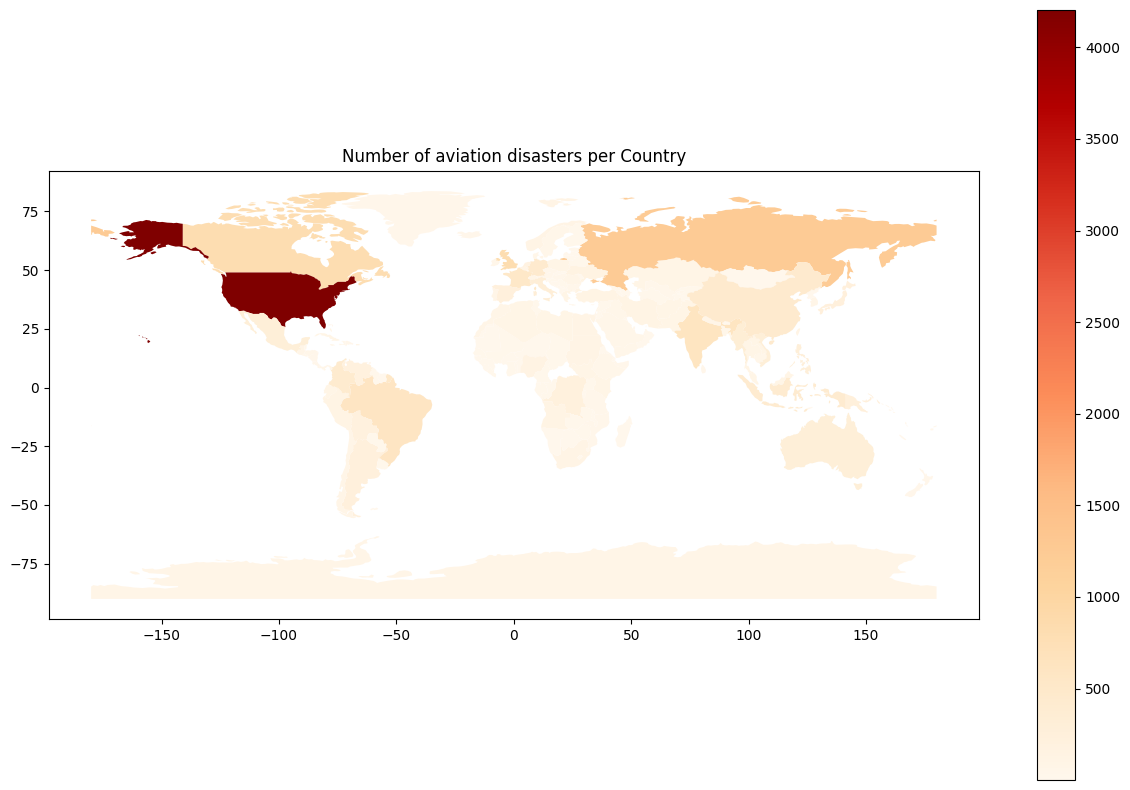

In [ ]:
# Creiamo il cartogramma
world.plot(column='accidents', cmap='OrRd', legend=True, figsize=(15, 10))
plt.title('Number of aviation disasters per Country')
plt.show()